In [1]:
using Distributions
using Plots
using PlotRecipes
using GLM
using LaTeXStrings
using DataFrames
gr()
#plotlyjs()

Plots.GRBackend()

In [2]:
function benardApprox(numberOfRanks)
  numSamples = collect(1:numberOfRanks)*1.0
  return(map(x -> (x - 0.3)/(numberOfRanks + 0.4), numSamples))
end

function bathtub_rate(x::Float64)
    thr1 = 2.0
    thr2 = 8.0
    rate1 = -3.0
    yval2 = 1.0
    rate3 = 3.0
    if x <= thr1
        y = rate1 * x + (yval2 - rate1 * thr1)
    elseif (x > thr1) && (x <= thr2)
        y = yval2
    else
        y = rate3 * x + (yval2 - rate3 * thr2)
    end
    return(y)
end

function iteratefits(samplelist, distfunc)
    result = DataFrame()
    for i in samplelist
        numSamples = i
        y = benardApprox(numSamples)
        ylog = map(x -> log(-log(1-x)), y)
        x = sort(rand(distfunc, numSamples))
        xlog = log.(x)
        df = DataFrame(x=xlog, y=ylog)
        fit_result = fit(LinearModel, @formula(y ~ x), df)
        df_new = DataFrame(sample_size=i,
            slope_val=coef(fit_result)[2],
            slope_err=stderr(fit_result)[2],
            intercept_val=coef(fit_result)[1],
            intercept_err=stderr(fit_result)[1],
        )
        result = vcat(result, df_new)
    end
    return(result)
end

function betaRanks(prob, n)
    numSamples = collect(1:n)*1.0
    return(map(x -> quantile(Beta(x, n-x+1), prob), numSamples))
end

rectangle(w, h, x, y) = Shape(x + [0,w,w,0], y + [0,0,h,h])

rectangle (generic function with 1 method)

In [3]:
numSamples = 1000;
y = benardApprox(numSamples);
ylog = map(x -> log(-log(1-x)), y);

k1 = 0.3;
k2 = 1.0;
k3 = 10.0;

l1 = 1.0;
l2 = 1.0;
l3 = 1.0;

wb1 = Weibull(k1, l1);
x1 = sort(rand(wb1, numSamples));
x1log = log.(x1);

wb2 = Weibull(k2, l2);
x2 = sort(rand(wb2, numSamples));
x2log = log.(x2);

wb3 = Weibull(k3, l3);
x3 = sort(rand(wb3, numSamples));
x3log = log.(x3);

# Failure rate analysis with the Weibull distribution
07.6.2018
by Stefan Schelm (stefan.schelm@runbox.com)

## Some infos
The Weibull function is:
- A continuous probability distribution
- Named after Swedish mathematician Waloddi Weibull
- First identified by Fréchet (1927)
- First applied by Rosin & Rammler (1933) to describe a particle size
	distribution
- There's even a standard (IEC 61649)
- There's a two and a three parameter version (adding a minimum lifetime parameter)


## Density function of a random Weibull variable $x$
### Probability Density Function:
$$
    f(x;\lambda,k) =
    \begin{cases}
    \frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1}e^{-(\frac{x}{\lambda})^{k}} & x\geq0 ,\\
    0 & x<0,
    \end{cases}
$$

### Cummulative Density Function:
$$
    F(x;\lambda,k) = 1-e^{-(x/\lambda )^{k}}
$$
---
$k > 0$ is the shape parameter

$\lambda > 0$ is the scale parameter (AKA characteristic lifetime)

For the three parameter version (with $x_{0}$ being the minimum lifetime): $x \rightarrow (x-x_{0}) $

In [4]:
wbex1 = Weibull(0.5,1.0);
wbex2 = Weibull(1.0,1.0);
wbex3 = Weibull(1.5,1.0);
wbex4 = Weibull(5.0,1.0);

xmin = 0.0;
xmax = 2.0;
ymin1 = 0.0;
ymax1 = 6.0;
ymin2 = 0.0;
ymax2 = 1.1;
clw = 5;

xcdf = linspace(xmin, xmax, 1000);
cdf1 = cdf.(wbex1, xcdf);
cdf2 = cdf.(wbex2, xcdf);
cdf3 = cdf.(wbex3, xcdf);
cdf4 = cdf.(wbex4, xcdf);

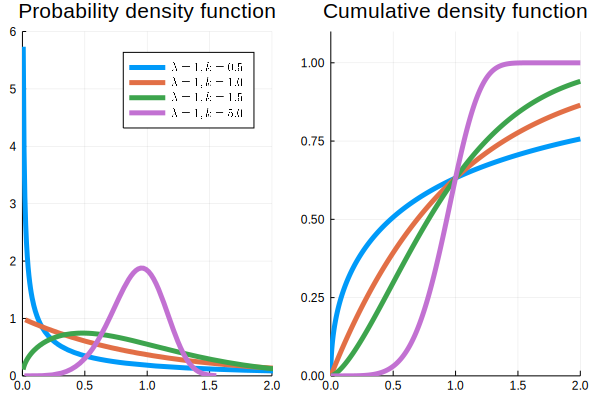

In [5]:
p1 = plot([wbex1, wbex2, wbex3, wbex4],
    xlims=(xmin, xmax),
    ylims=(ymin1, ymax1),
    linewidth=clw,
    title="Probability density function",
    label=[L"\lambda = 1, k = 0.5", L"\lambda = 1, k = 1.0", L"\lambda = 1, k = 1.5", L"\lambda = 1, k = 5.0"])

p2 = plot(xcdf, [cdf1, cdf2, cdf3, cdf4],
    xlims=(xmin, xmax),
    ylims=(ymin2, ymax2),
    linewidth=clw,
    title="Cumulative density function",
    legend=:none)

plot(p1,p2)
#savefig("pdf_cdf.png")

## Failure analysis
In many cases of statistical analysis, the structure of interest is the frequency distribution of the variable, i.e. the probability distribution function (PDF, the complete version of a histogram).

For failure analysis it is often more desirable to determine a somewhat statistical chronology of the process. This can be represented by the cummulative distribution function (CDF).

## The bathtub curve
The bathtub is a representation of a rather common case, where three failure modes can be distinguished:

1. Early failures with a failure rate which decreases over time (infant or early mortality)
1. Failures where the failure rate is constant over time
1. Late failures with a failure rate which increases over time (ageing, wear out)

All three parts can be described by a Weibull distribution with different shape factors, <1, ==1 and >1, respectively.

The case of the constant failure rate is often the one of interest but failure analysis can also be used to determine the different regions and e.g. determine a suitable time for a burn-in process during production. Using a suitable burn-in time and assuming there is no additional failure mode, whih would create additional short-term failures after this time, units delivered to customers should in this case show no short-term failures.

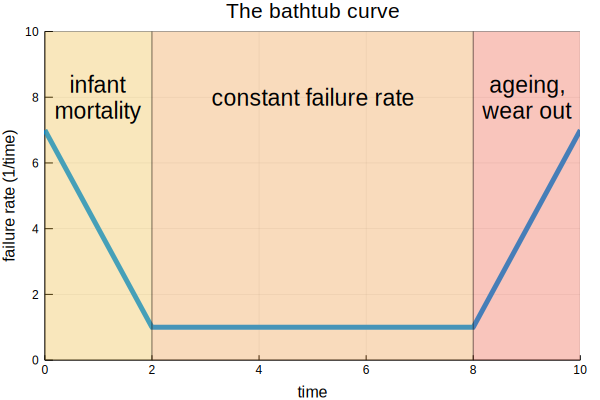

In [6]:
xend = 10;
xbt = linspace(0, xend, 1000);
ybt = map(y -> bathtub_rate(y), xbt);

plot(xbt, ybt,
    linewidth = 5,
    xlabel = "time",
    ylabel = "failure rate (1/time)",
    ylims = (0, xend),
    legend = :none)
annotate!([(1,8,text("infant\nmortality",16,:black,:center)),
        (5,8,text("constant failure rate",16,:black,:center)),
        (9,8,text("ageing,\nwear out",16,:black,:center))
        ])
plot!(rectangle(2,10,0,0), opacity=.3, color=colorant"#EAAE21")
plot!(rectangle(6,10,2,0), opacity=.3, color=colorant"#EA8621")
plot!(rectangle(2,10,8,0), opacity=.3, color=colorant"#EA3C21")
title!("The bathtub curve")
#savefig("bathtub2.png")

## General approach
The general approach can be sumnmed up as follows:

1. Order failures according to increasing life time (ranking)
2. Assign each failure a failure rate $y$ value
3. Analyse the structure of failure rate as a function of life time. Numerically, this can be done either by using a linear regression (see below) or a maxiumum likelihood estimation.

This can also be used graphically, in the case of the Weibull distribution with a double log plot with the CDF.
$$
\begin{aligned}
F(x) &= 1-e^{-(x/\lambda )^{k}}\\
-\ln(1-F(x)) &= (x/\lambda )^{k}\\
\underbrace {\ln(-\ln(1-F(x)))} _{\textrm {'y'}} &= \underbrace {k\ln x} _{\textrm {'mx'}}-\underbrace {k\ln \lambda } _{\textrm {'c'}}
\end{aligned}
$$

This general approach can also be used with other distribution functions.

## The difficulty with the failure ranking values ($y$ values)
How do you determine the y-values, i.e. the concrete failure ranking or percentage value, for this approach?

The meaning of the ranking values is the corresponding unreliability for the respective failures.

How about $i/n$?
Where $n$ is the total number of samples and $i$ the i-th failure count.
This works but it requires a decent sample count ($\geq 30$).

A more precise way to do it is to use the 50% percentile of the Beta distribution, using $i$ and $n-i+1$ as parameters.

If the Beta based calculation or respective tables are not available, the Benard approximation can be used:
$$
MR_{Benard} = \frac{i-0.3}{n+0.4}
$$

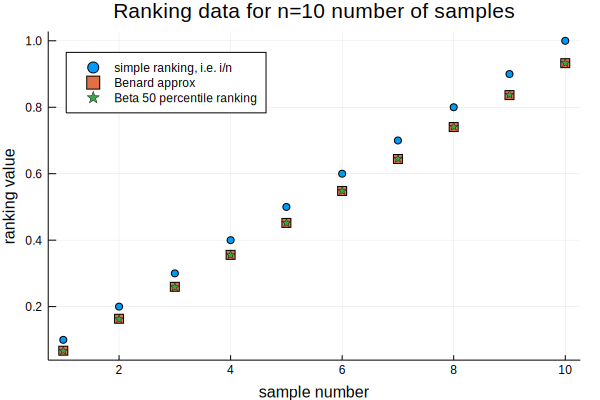

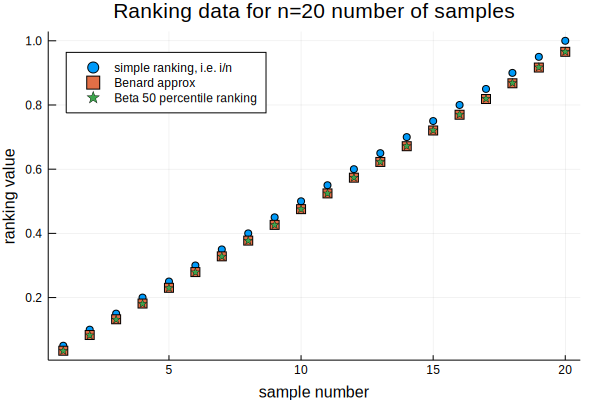

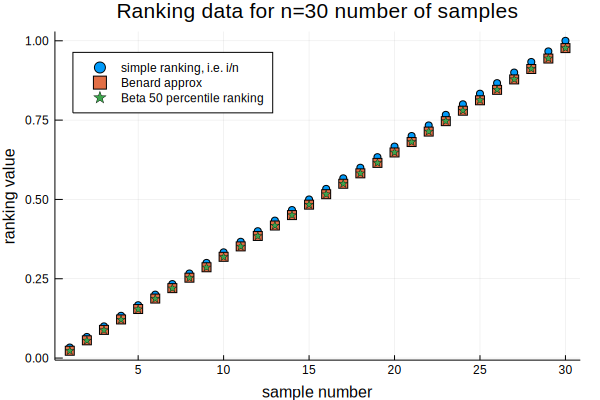

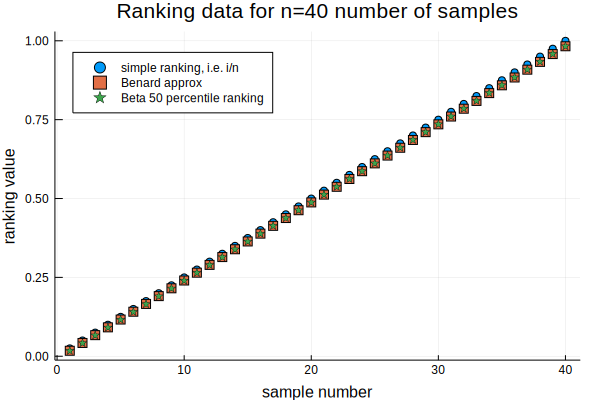

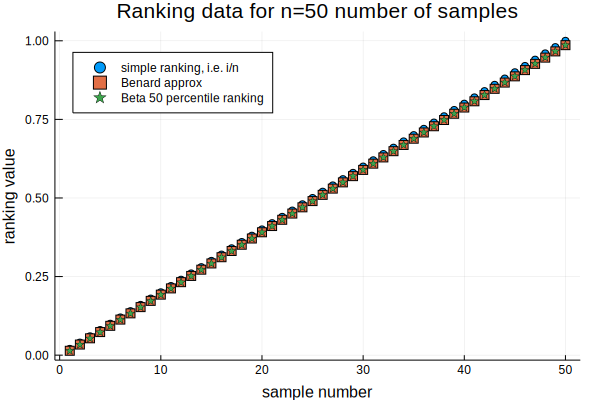

In [7]:
for n in 10:10:50
    xvals = collect(1:n)*1.0
    simple_ranks = xvals./n
    benard_ranks = benardApprox(n)
    beta_ranks = betaRanks(0.5, n)
    scatter(xvals, simple_ranks, label = "simple ranking, i.e. i/n",
        legend = :topleft,
        markershape = :auto)
    scatter!(xvals, benard_ranks, label = "Benard approx",
        legend = :topleft,
        markershape = :auto)
    scatter!(xvals, beta_ranks, label = "Beta 50 percentile ranking",
        legend = :topleft,
        markershape = :auto)
    title!("Ranking data for n="*string(n)*" number of samples")
    xlabel!("sample number")
    display(ylabel!("ranking value"))
end


## Censored and suspended data
Failure analysis provides ways to handle incomplete data, i.e. censored data.

Reasons for censoring can be:

1. Exact failure time is unkown (interval censoring)
1. Failure mode differs from expected one
1. Samples survived end of experiment (suspended or right-censored data)

One way to handle censored data is by adjusting the ranking:
$$
adjusted\_rank = \frac{inverse\_rank \times previous\_adjusted\_rank + (n+1)}{inverse\_rank + 1}
$$

In [8]:
df_censored = DataFrame(
    ranking = [1,2,3,4,5,6,7,8],
    inverse_ranking = [8,7,6,5,4,3,2,1],
    fail_time_m = [10,30,45,49,82,90,96,100],
    status = ["censored","fail","censored","fail","fail","fail","fail","suspended"],
    adjusted_rank_txt = ["censored","[7 × 0 +(8+1)]/(7+1) = 1.125","censored","[5 × 1.125 +(8+1)]/(5+1) = 2.438","[4 × 2.438 +(8+1)]/(4+1) = 3.750","[3 × 3.750 +(8+1)]/(3+1) = 5.063","[2 × 5.063 +(8+1)]/(2+1) = 6.375","suspended"],
    adjusted_rank = [NaN,1.125,NaN,2.438,3.75,5.063,6.375,NaN],
    median_rank_benard = [NaN,0.098,NaN,0.255,0.411,0.567,0.723,NaN])
display(df_censored)
df_censored[:median_rank_benard_log] = map(x -> log(-log(1-x)), df_censored[:median_rank_benard])
df_censored[:fail_time_m_log] = log(df_censored[:fail_time_m])
#display(df_censored)
df_censored_filtered = df_censored[!isnan.(df_censored[:median_rank_benard]),:];

,ranking,inverse_ranking,fail_time_m,status,adjusted_rank_txt,adjusted_rank,median_rank_benard
1,1,8,10,censored,censored,NaN,NaN
2,2,7,30,fail,[7 × 0 +(8+1)]/(7+1) = 1.125,1.125,0.098
3,3,6,45,censored,censored,NaN,NaN
4,4,5,49,fail,[5 × 1.125 +(8+1)]/(5+1) = 2.438,2.438,0.255
5,5,4,82,fail,[4 × 2.438 +(8+1)]/(4+1) = 3.750,3.75,0.411
6,6,3,90,fail,[3 × 3.750 +(8+1)]/(3+1) = 5.063,5.063,0.567
7,7,2,96,fail,[2 × 5.063 +(8+1)]/(2+1) = 6.375,6.375,0.723
8,8,1,100,suspended,suspended,NaN,NaN


In [39]:
##  test adjusted rank calculation
(2.438 - 0.3)/(8 + 0.4)

0.25452380952380954

In [9]:
df_not_censored = DataFrame(
    ranking = [1,2,3,4,5],
    fail_time_m = [30,49,82,90,96],
    median_rank_benard = benardApprox(5))
df_not_censored[:median_rank_benard_log] = map(x -> log(-log(1-x)), df_not_censored[:median_rank_benard])
df_not_censored[:fail_time_m_log] = log(df_not_censored[:fail_time_m])
display(df_not_censored)

,ranking,fail_time_m,median_rank_benard,median_rank_benard_log,fail_time_m_log
1,1,30,0.12962962962962962,-1.9744586943793727,3.4011973816621555
2,2,49,0.31481481481481477,-0.9726861412053714,3.8918202981106265
3,3,82,0.5,-0.36651292058166435,4.406719247264253
4,4,90,0.6851851851851851,0.1447673963435997,4.499809670330265
5,5,96,0.8703703703703703,0.7144554862576666,4.564348191467836


In [10]:
fit_censored = fit(LinearModel, @formula(median_rank_benard_log ~ fail_time_m_log), df_censored_filtered);
fit_not_censored = fit(LinearModel, @formula(median_rank_benard_log ~ fail_time_m_log), df_not_censored);
#println(fit_censored)
#println(fit_not_censored)

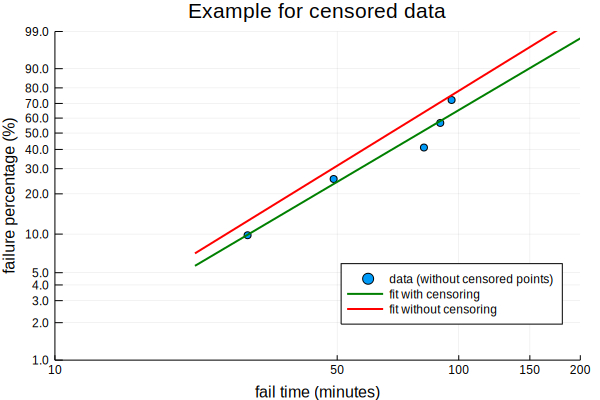

In [11]:
xmin = 0
xmax = 200
#xmmlab = collect(xmin:20:xmax)
xmmlab = [10, 50, 100, 150, 200]
xmmloglab = log.(xmmlab)
#ymmlab = collect(0.1:0.1:0.9)
ymmlab = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
ymmloglab = map(x -> log(-log(1-x)), ymmlab)

x_fit = log.(linspace(xmin, xmax, 10))
y_fit_censored = coef(fit_censored)[2] * x_fit + coef(fit_censored)[1]
y_fit_not_censored = coef(fit_not_censored)[2] * x_fit + coef(fit_not_censored)[1]

scatter(log.(df_censored[:fail_time_m]), map(x -> log(-log(1-x)), df_censored[:median_rank_benard]),
    label = "data (without censored points)",
    legend = :bottomright,
    xlims = (log(xmin),log(xmax)),
    ylims = (log(-log(1-0.01)), log(-log(1-0.99))),
    yticks = (ymmloglab, round.(ymmlab*100)),
    xticks = (xmmloglab, xmmlab))
plot!(x_fit, y_fit_censored, color = :green, linewidth = 2, label = "fit with censoring")
plot!(x_fit, y_fit_not_censored, color = :red, linewidth = 2, label = "fit without censoring")
title!("Example for censored data")
xlabel!("fail time (minutes)")
ylabel!("failure percentage (%)")

## $B..$-life
The $B..$-life is a way to express characteristic life times for failure analysis.

A usual case is the $B10$ value which needs to be determined and stated in customer informations e.g. for safety relays or electromechanical components in a functional safety setting (in which case it should be the $B10d$ value for dangerous (i.e. non-detectable) failures). Functional safety settings usually require one failure redundancy setups or components for the higher safety classifications.

The $B10$ value is the time at which 10% of the samples **statistically** have failed. This forms the base for certain risk calculations in a functional safety setting for machinery. These values could also be used in other risk assessments, e.g. in order to adjust maintenance cycles or pre-emptive part replacements.

The values can be determined graphically by using the 10% horizontal line in the Weibull plot, numerically from a fit in a similar way or as the 10% quantile value from a Weibull distribution, using the parameters determined by a fit.

For $B10$, from $\ln(\ln(\frac{1}{1-0.10}))\overset{!}{=}k\ln x_{B10}-k\ln \lambda$  follows:  $x_{B10} = \lambda(\ln(\frac{1}{0.9}))^{1/k}$

The shape value $k$ can be determined from the slope and the scaling factor $\lambda$, using the shape value, from the intercept.

## Example: B10 life value determination

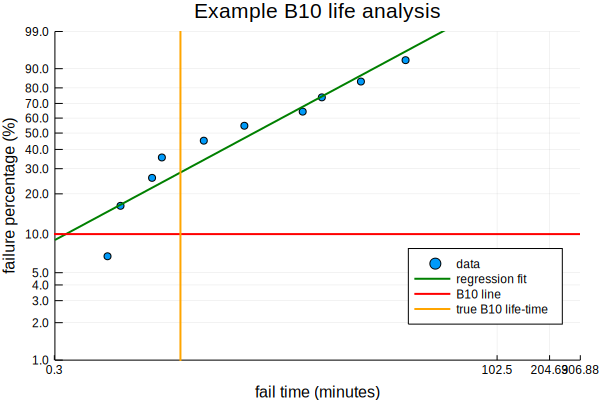

B10_life_true (from distribution definition) = 1.580408
B10_life_fitD (from fitted pars, direct) = 0.349215
B10_life_fitQ (from fitted pars, via quantile @ 0.1) = 0.349215


In [15]:
numSamples = 10
y = benardApprox(numSamples)
ylog = map(x -> log(-log(1-x)), y)

wbB10 = Weibull(1.0, 15)
xB10 = sort(rand(wbB10, numSamples))
xB10log = log.(xB10)
xmin = 0.5*xB10[1]
xmax = 10*xB10[end]

df_B10 = DataFrame(
    ranking = collect(1:numSamples),
    fail_time_m = xB10,
    median_rank_benard = y,
    median_rank_benard_log = ylog,
    fail_time_m_log = xB10log)

fit_B10 = fit(LinearModel, @formula(median_rank_benard_log ~ fail_time_m_log), df_B10);
x_fit = log.(linspace(xmin, xmax, 10))
y_fit = coef(fit_B10)[2] * x_fit + coef(fit_B10)[1]

k_B10 = coef(fit_B10)[2]
lambda_B10 = exp(-1*coef(fit_B10)[1]/k_B10)

xmmlab = collect(round.(linspace(xmin, xmax, 4),2))
xmmloglab = log.(xmmlab)
ymmlab = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
ymmloglab = map(x -> log(-log(1-x)), ymmlab)

b10_true = quantile(Weibull(1.0, 15), 0.1)
b10_fitD = lambda_B10*(log(1/0.9))^(1/k_B10)
b10_fitQ = quantile(Weibull(k_B10, lambda_B10), 0.1)

scatter(log.(df_B10[:fail_time_m]), map(x -> log(-log(1-x)), df_B10[:median_rank_benard]),
    label = "data",
    legend = :bottomright,
    xlims = (log(xmin),log(xmax)),
    ylims = (log(-log(1-0.01)), log(-log(1-0.99))),
    yticks = (ymmloglab, round.(ymmlab*100)),
    xticks = (xmmloglab, xmmlab))
plot!(x_fit, y_fit, color = :green, linewidth = 2, label = "regression fit")
hline!([log(-log(1-0.1))], color =:red, linewidth = 2, label = "B10 line")
vline!([log(b10_true)], color =:orange, linewidth = 2, label = "true B10 life-time")
title!("Example B10 life analysis")
xlabel!("fail time (minutes)")
display(ylabel!("failure percentage (%)"))

prec = 6
println("B10_life_true (from distribution definition) = "*string(round(b10_true, prec)))
println("B10_life_fitD (from fitted pars, direct) = "*string(round(b10_fitD, prec)))
println("B10_life_fitQ (from fitted pars, via quantile @ 0.1) = "*string(round(b10_fitQ, prec)))

## Example: 3 parameter Weibull

![3 parameter Weibull](w3pplot.png)
(from [SAS support page](http://support.sas.com/documentation/cdl/en/qcug/63964/HTML/default/images/w3pplot.png))

## Example: Impact of sample size

In [16]:
samplelist = [10, 100, 1000, 10_000, 100_000, 1_000_000];
fit_data1 = iteratefits(samplelist, Weibull(0.3,1));
fit_data2 = iteratefits(samplelist, Weibull(1.0,1));
fit_data3 = iteratefits(samplelist, Weibull(10.0,1));

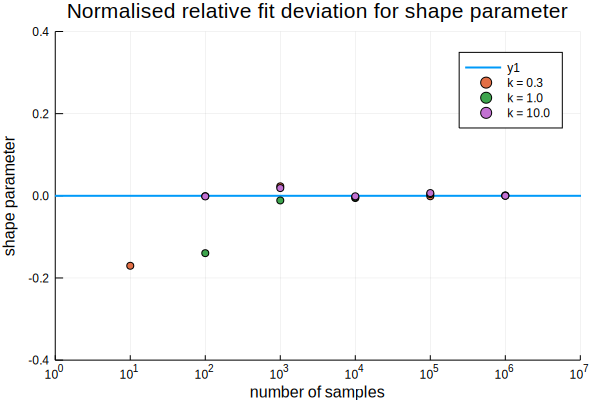

In [17]:
hline([0.0], linewidth=2,
    xscale=:log10,
    xlims=(1,1e7),
    ylims=(-0.4,0.4),
    xlabel="number of samples",
    ylabel="shape parameter",
)
scatter!(fit_data1[:sample_size], (fit_data1[:slope_val]-k1)/k1,
    label = "k = " * string(k1)
)
scatter!(fit_data2[:sample_size], (fit_data2[:slope_val]-k2)/k2,
    label = "k = " * string(k2))
scatter!(fit_data3[:sample_size], (fit_data3[:slope_val]-k3)/k3,
    label = "k = " * string(k3))
title!("Normalised relative fit deviation for shape parameter")

## Example: Mixture models

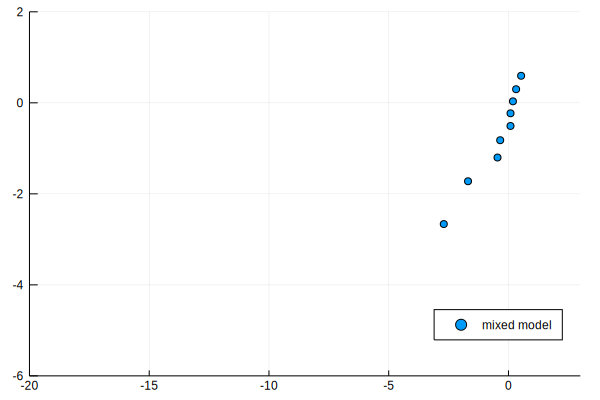

In [26]:
mm1 = MixtureModel(
   [Weibull(k1, l1),
   Weibull(k2, l2),
   Weibull(k3, l3)], [0.1, 0.7, 0.2]);

numSamples = 10
ymm = benardApprox(numSamples);
ymmlog = map(x -> log(-log(1-x)), ymm);
ymmlab = collect(0.1:0.1:0.9);
ymmloglab = map(x -> log(-log(1-x)), ymmlab);

xmm = sort(rand(mm1, numSamples));
xmmlog = log.(xmm);

scatter(xmmlog, ymmlog, label = "mixed model",
    xlims = (-20.0, 3.0),
    ylims = (-6.0, 2.0),
    legend = :bottomright)

## "You have chosen ... wisely" - The importance of choosing a specific distribution
A distribution based statistical approach will yield results in many cases when using different distributions.
Choosing a specific distribution has therefore important implications.
__When you decide on a particular distribution you decide on a particular scientific model which is _represented_ by that distribution.__
While it is possible to use such an approach to test the quality of fit for different distributions, it is better to have an understanding of the basic scientific structure of your underlying process, which -in turn- defines the distribution which you should use.

Application examples of common distributions:

- Weibull
    - Wind speed distributions
    - Insurance claims
    - Forecasting technological change
    - Particle size distribution, for particles generated by grinding, milling and crushing
    - Electronic componentn failures

- Log-Normal
    - Length of comments posted in Internet discussion forums
    - Measures of size of living tissue
    - Particle size distributions (there are some differences between using Weibull and Log-Normal for this, see [Wikipedia](https://en.wikipedia.org/wiki/Weibull_distribution#Applications))
    - Income distribution
    - City sizes
    - File size distribution
    - Length of chess games
    
- Rayleigh distribution
    - Noise variance estimation in MRI
    - Dietary nutrient level responses
    - Wind speed distribution, based on vectorial representations

## The complexity of even a simple distribution based approach
Even simple distribution based approaches quickly reach a cummulated complexity due to the number of steps and possible parameters involved.
This should give you an idea, what kind of information _should_ (but unfortunately often isn't) be provided by a statistical analysis.

The following list describes the individual steps for an analysis similar to the one presented:

1. Choose data: Are you censoring data? Which data? Why?
1. Choose model (distribution): Which distribution? Why?
1. Choose ranking method: simple ranking, Benard or Beta based?
1. Fitting data to a model: What fit algorithm are you using? Regression? MLE?
1. How good is the fit?
1. Are there structures in the data which might not align well with your model? 3 paramater Weibull needed? Possible multiple distributions?

A collection of single choices (e.g. log-normal vs. Weibull for particle size, or different ranking methods for small sample sizes) can therefore yield different results. But even in cases where the differences are small, those differences may have a big impact (see e.g. extreme value analysis).

## Confidence intervals
Confidence intervals (CI) are a very important tool to determine the level of confidence for a statistical approach.

Unfortunately CIs are conceptionally not really simple and can be calculated (apart from a few simple cases) in different ways (e.g. Beta-Binomial, Fisher Matrix, Likelihood Ratio Confidence).
These ways yield either more conservative (wider) or more optimistic (narrower) confidence margins.

One often cited definition of CIs is similar to the following description:

"For a confidence interval of $P$, there is a probability of $P$ that the respective parameter lies within the interval."

This is __not__ correct! The difference to the correct definition may be small in many cases and sound very similar but it is important to acknowledge the difference and to remember the correct meaning.

The correct definition is as follows:

"There is a probability $P that the calculated confidence interval from some future experiment contains the true value of the respective parameter."

"For a confidence interval of $P$, in $P$ % of all experiments the calculated interval will contain the true parameter."

## CIs vs. p-value
A statistical analysis will often use a hypothesis test of the suggested model (usually against the null hypothesis).
In order to determine the reliability or significance of the test, the $p$-value is often used. Commonly with the value 0.05.
While this is an established procedure, there is a certain amount of arbitrariness involved (0.05 is only a convention) and it's precise meaning can be misunderstood.

See this comic from xkcd:
![Significance](significant.png)
(from [xkcd](https://xkcd.com/882/))

For a good introduction and discussion of this topic, see the book [Statistics Done Wrong](https://www.statisticsdonewrong.com) by Alex Reinhart.

## Example: Beta-Binomial confidence intervalls

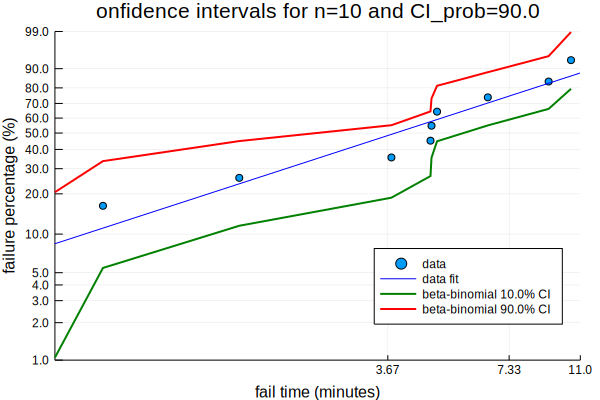

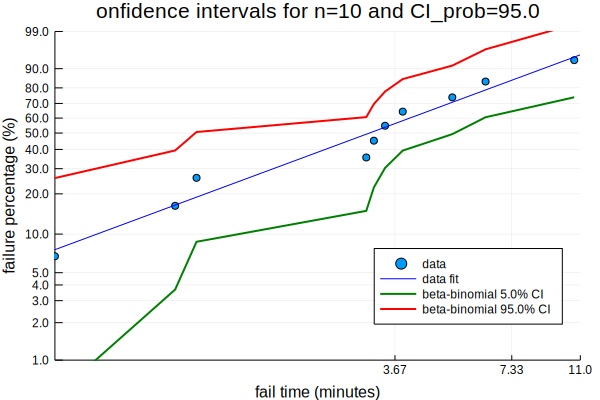

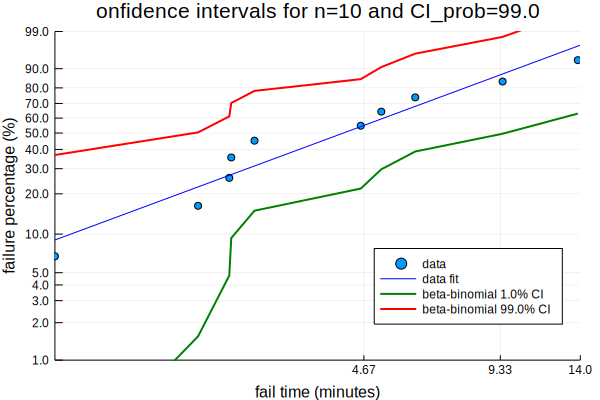

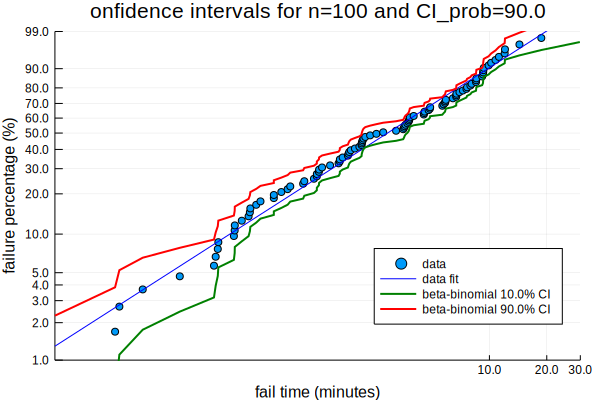

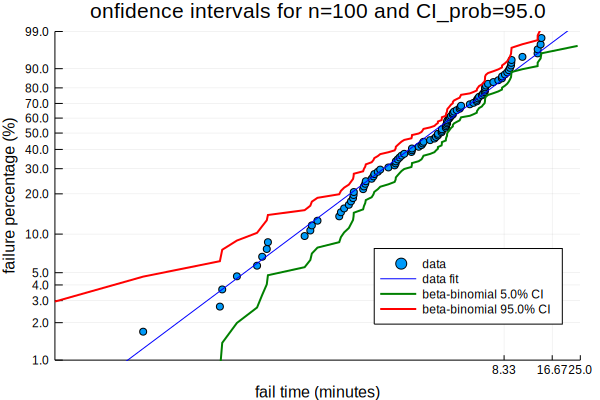

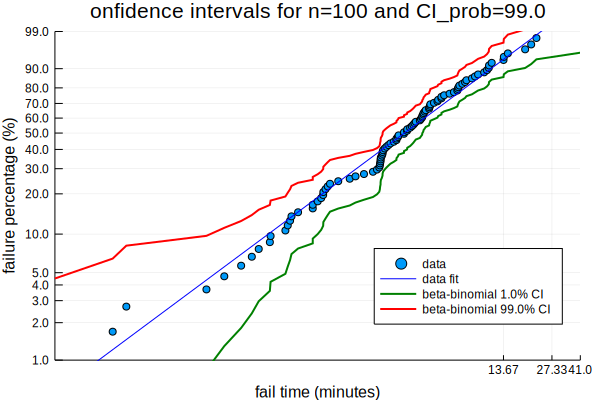

In [27]:
numSamples = [10,100]
k = 1.0
l = 5.0
confidence_levels = [0.9, 0.95, 0.99]

for i in numSamples, j in confidence_levels
    y = benardApprox(i)
    ylog = map(x -> log(-log(1-x)), y)
    ylb = betaRanks(1-j, i)
    yloglb = map(x -> log(-log(1-x)), ylb)
    yhb = betaRanks(j, i)
    yloghb = map(x -> log(-log(1-x)), yhb)

    wb = Weibull(k, l)
    x = sort(rand(wb, i))
    xlog = log.(x)
    #println(x)
    #println(xlog)
    
    cdf = DataFrame(
        ranking = collect(1:i),
        fail_time_m = x,
        median_rank_benard = y,
        median_rank_benard_log = ylog,
        fail_time_m_log = xlog
        )
    
    cfit = fit(LinearModel, @formula(median_rank_benard_log ~ fail_time_m_log), cdf)
    
    xmin = 0.0
    xmax = ceil(x[end])

    xmmlab = collect(round.(linspace(xmin, xmax, 4),2))
    xmmloglab = log.(xmmlab)
    ymmlab = [0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
    ymmloglab = map(x -> log(-log(1-x)), ymmlab)
    
    xfit = log.(linspace(x[1], xmax, 10))
    yfit = coef(cfit)[2] * xfit + coef(cfit)[1]
    
    scatter(xlog, ylog,
        label = "data",
        legend = :bottomright,
        xlims = (log(xmin),log(xmax)),
        ylims = (log(-log(1-0.01)), log(-log(1-0.99))),
        yticks = (ymmloglab, round.(ymmlab*100)),
        xticks = (xmmloglab, xmmlab)
        )
    plot!(xfit, yfit, color = :blue, linewidth = 1, label = "data fit")
    plot!(xlog, yloglb, color = :green, linewidth = 2, label = "beta-binomial "*string(round(100*(1-j)))*"% CI")
    plot!(xlog, yloghb, color = :red, linewidth = 2, label = "beta-binomial "*string(round(100*j))*"% CI")
    title!("onfidence intervals for n="*string(i)*" and CI_prob="*string(round(100*j)))
    xlabel!("fail time (minutes)")
    display(ylabel!("failure percentage (%)"))
end

## References
https://en.wikipedia.org/wiki/Weibull_distribution

http://www.weibull.com/

https://en.wikipedia.org/wiki/Confidence_interval

https://en.wikipedia.org/wiki/P-value

https://en.wikipedia.org/wiki/Misunderstandings_of_p-values

## _"So Long, and Thanks for All the Fish"_

## Original data for number of samples impact

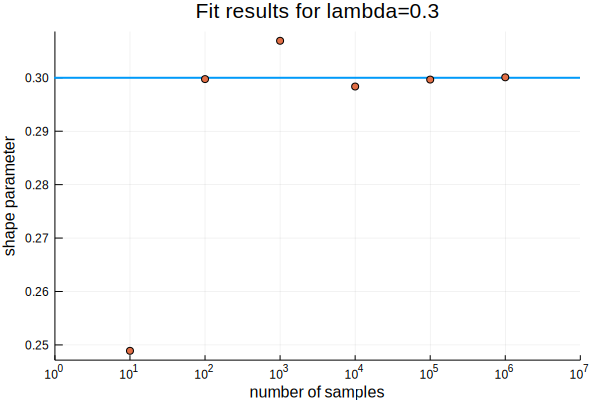

In [18]:
hline([0.3], linewidth=2,
    xscale=:log10,
    xlims=(1,1e7),
    xlabel="number of samples",
    ylabel="shape parameter",
    legend=:none,
    title="Fit results for lambda=0.3"
)
scatter!(fit_data1[:sample_size], fit_data1[:slope_val])
#savefig("fitres_03.png")

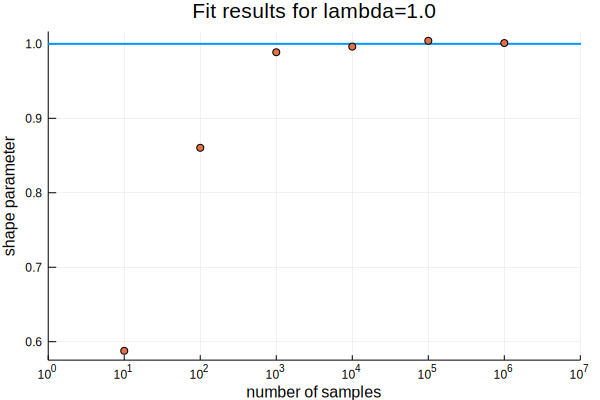

In [19]:
hline([1.0], linewidth=2,
    xscale=:log10,
    xlims=(1,1e7),
    xlabel="number of samples",
    ylabel="shape parameter",
    legend=:none,
    title="Fit results for lambda=1.0"
)
scatter!(fit_data2[:sample_size], fit_data2[:slope_val])
#savefig("fitres_1.png")

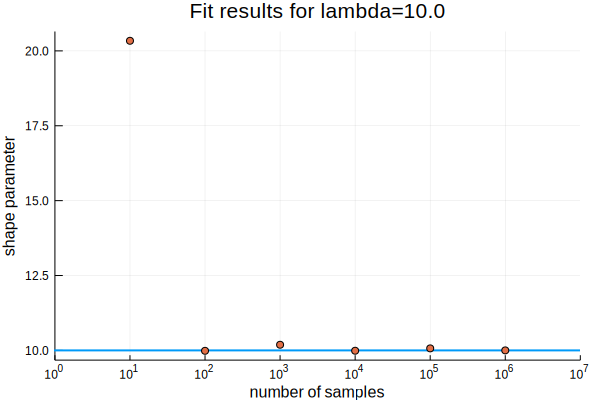

In [20]:
hline([10.0], linewidth=2,
    xscale=:log10,
    xlims=(1,1e7),
    xlabel="number of samples",
    ylabel="shape parameter",
    legend=:none,
    title="Fit results for lambda=10.0"
)
scatter!(fit_data3[:sample_size], fit_data3[:slope_val])
#savefig("fitres_10.png")